***
<left>
    <img style="float: left;" src="module6_heading.jpeg" width="800"></img>
</left>

<br/><br/>
<br/><br/>

### Meanwhile you have learned a lot about Models for Learning already. Go through the following self-study material to discover more examples, deepen your knowledge and broaden your view. Make sure to carefully read through the following text, the more thorough you will go through the summary, the easier you will find the assignment. 

# Supervised learning

## Tree-Based Methods

In this section you will learn more about additional supervised machine learning methods.

### Random Forest

As you have seen earlier in this course, one problem with decision trees is that they have very high complexity, i.e. we can use the terminology small bias and large variance. For instance, recall the example of a decision tree using the Iris dataset. Note that the training scores are all $1.0$, this means that we have fit the model perfectly to the training data. Something like this is usually a sign of overfitting/overlearning, in real life we almost never get results this good: see also the test errors which are not $1.0$. Is this overfitting a problem? This depends – if you get a poor test score you can try to do model selection to find something that is overfitting less. Hopefully the test score will improve.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

iris = pd.read_csv('../../Data/iris.csv')
iris = iris[iris.columns[1:]]
iris.head(2)

feature_columns = iris.columns[:4]
target_column = iris.columns[-1]
X = iris[feature_columns]
y = iris[target_column]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X,y,test_size=0.3,random_state=1235)

In [12]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(random_state=100)
dct.fit(X_train_c,y_train_c)

DecisionTreeClassifier(random_state=100)

In [13]:
from sklearn.metrics import classification_report

print("""################### Training Report #################
""")

print(classification_report(y_train_c,dct.predict(X_train_c)))

print("""
##################### Test Report ###################
""")

print(classification_report(y_test_c,dct.predict(X_test_c)))

################### Training Report #################

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       1.00      1.00      1.00        33
   virginica       1.00      1.00      1.00        38

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105


##################### Test Report ###################

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       1.00      0.88      0.94        17
   virginica       0.86      1.00      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



Is there a way to reduce the variance of the model without sacrificing the bias? We would like to take the average of several models to obtain a more stable model. Luckily, there is a way, and this is called **ensemble methods**. Random forest is one of several ensemble methods that is based on decision trees. The idea of this section is to give a general overview of the basic random forest algorithm and then to describe how this method can be applied to **classification** and **regression** problems.

#### Bootstrap aggregation (Bagging)

The first idea behind a random forest is something called [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). The idea is to sample multiple times from the dataset, each time building a tree, and then use the **forest** of trees to make the prediction, applying the averaging process.

Suppose we are provided with a dataset $X = \{X_1,\ldots,X_n\}$. We sample from this dataset with replacement $n$ times and end up with a subset $\tilde X$. It is important to remember, that sometimes the same datapoint can be sampled more than once, however we only include unique datapoints, i.e. it will only be included once. This leads to the peculiar fact that in average the sampled set $\tilde X$ is of size $\approx 63\%$ of the size of $X$, or, strictly speaking, $1-1/e$.

What is the statistical idea behind this sampling? Basically, we want to have several datasets that are sampled from the same distribution. However, since we do not know the true distribution, we use the empirical distribution. This is exactly the same as sampling from the dataset $X$ with replacement.

Let us now toy with the idea of sampling several sets $\tilde X^i$, $i=1,\ldots, m$ and train a tree on each set $\tilde X^i$. The resulting set of trees is called a **forest**. How these trees are used to make a prediction is the **aggregation** part of **bagging**, that will be covered below. 

##### Classification

When random forest is used to predict the class of a new observation, each individual decision tree initially generates a prediction. Next we would like to combine these predictions to output a single prediction. The most common way of doing this is to think of each prediction as a vote for which class the observation should belong to. The final prediction of the random forest classifier corresponds to **the class that received the most votes**, a so called majority voting scheme.

##### Regression

Similarly, in a random forest model for regression, each individual tree will output a value. In this case the standard approach for combining the predictions is to calculate **the average of the output from each tree**.

#### Bagging the features

The basic idea of random forest is that we want a large collection of decorrelated trees, however just bootstrapping is not enough to make the trees decorrelated. The average of $M$ independent and identically distributed (i.i.d.) random variables each with variance $\sigma^2$ has variance

$$\frac{1}{M} \sigma^2.$$

If the variables are not independent but identically distributed (i.d.) then the variance of the average depends on the correlation between the datapoints. Let us say that the pairwise correlation between two variables is $\rho \in (0,1)$, then the average has variance

$$\rho \sigma^2 + \frac{1-\rho}{M} \sigma^2$$

and we note that the second term can be made small with many trees, the first term cannot be made smaller than the initial correlation between the variables. Thus we need a method to decorrelate the trees. The way the random forest algorithm tries to remedy this is by random selection of features in the trees: there are two main ways of doing this. Let us first consider the random subspace method.

##### Random subspace method

The idea of the **random subspace method** is very similar to the bootstrapping part above, but instead of sampling the datapoints with replacement, for each tree we sample from the set of features with replacement and use those sampled features for the tree. In other words, the [algorithm](https://en.wikipedia.org/wiki/Random_subspace_method) proceeds as follows

1. Let the number of training points be $N$ and the number of features in the training data be $p$.
2. Choose $M$ to be the number of individual models in the ensemble.
3. For each individual model $m$ to be trained, choose $d_m$ $(d_m < p)$ to be the number of input variables for $m$. It is common to have only one value of $d_m$ for all the individual models.
4. For each individual model $m$ to be trained, create a training set by randomly choosing $d_m$ features from $p$ and train $m$.

##### Random selection at each split

The other way to decorrelate the trees is, instead of randomly selecting the features before building each tree, to randomly select the features at each split.

##### Full random forest algorithm

This is an algorithm for a **random selection at each split**.
Set the number of trees to be $M$ and let the training data consist of $N$ observations and $p$ features:

1. For $m = 1,\ldots,M$ do the following:
    1. Draw a bootstrap sample $\tilde X$ of size $N$ from the training data.
    2. Grow a decision tree $T_m$ on the bootstrapped data $\tilde X$ as above, but at each node do the following (until some stopping criterion is reached):
        1. select $d$ variables at random from the $p$ feature variables
        2. select the best split among them
        3. split the node into two daughter nodes
2. Return the ensemble of trees $\{T_m\}_1^M$.

To make a prediction do as follows:

*Regression*: Use the average of the predictions from each tree in the ensemble.

*Classification*: Use a majority vote from each prediction from each tree in the ensemble.

#### Example

Let us try out the random forest algorithm and see if it fixes the overfitting problem that we had above.

In [14]:
from sklearn.ensemble import RandomForestClassifier
rft = RandomForestClassifier(n_estimators=100,random_state=1)
rft.fit(X_train_c,y_train_c)

from sklearn.metrics import classification_report

print("""################### Training Report #################
""")

print(classification_report(y_train_c,rft.predict(X_train_c)))

print("""
##################### Test Report ###################
""")

print(classification_report(y_test_c,rft.predict(X_test_c)))

################### Training Report #################

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       1.00      1.00      1.00        33
   virginica       1.00      1.00      1.00        38

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105


##################### Test Report ###################

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       1.00      0.82      0.90        17
   virginica       0.80      1.00      0.89        12

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.95      0.93      0.93        45



So the generalization error is about the same and we still fit the training data perfectly. This example is a bit contrived as we have such a small dataset. Let us try with a bigger dataset.

In [15]:
# For simplicity we will construct a classification dataset with two features and two classes
from sklearn.datasets import make_classification

X_data, y_data = make_classification(n_samples=20000, 
                                     n_features=100, 
                                     n_informative=30, 
                                     n_redundant=30, 
                                     n_repeated=10, 
                                     n_classes=2, 
                                     n_clusters_per_class=10, 
                                     weights=None, 
                                     flip_y=0.4, 
                                     class_sep=0.01, 
                                     hypercube=False, 
                                     shift=2.0, 
                                     scale=1.0, 
                                     shuffle=True, 
                                     random_state=10)


In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=.50 ,random_state=2)

In [17]:
from sklearn.tree import DecisionTreeClassifier

dct = DecisionTreeClassifier()
dct.fit(X_train,y_train)

from sklearn.metrics import roc_auc_score

print("Training AUC: %.2f" % roc_auc_score(y_train,dct.predict_proba(X_train)[:,1]))
print("Test AUC: %.2f" % roc_auc_score(y_test,dct.predict_proba(X_test)[:,1]))

Training AUC: 1.00
Test AUC: 0.52


We are now completely overfitting and the AUC on the test set is around $0.5$. Let us see what difference a random forest makes.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rft = RandomForestClassifier(n_estimators=1000,random_state=1,n_jobs=-1)
rft.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=1)

In [10]:
from sklearn.metrics import roc_auc_score

print("Training AUC: %.2f" % roc_auc_score(y_train,rft.predict_proba(X_train)[:,1]))
print("Test AUC: %.2f" % roc_auc_score(y_test,rft.predict_proba(X_test)[:,1]))

Training AUC: 1.00
Test AUC: 0.65


Here we can see a big difference between the decision tree and random forest models. Recall that the [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) measures the probability of correctly classified datapoints, so the value of $\approx 0.5$ means that, given that we have a 50/50 split, we are not doing much better than random on the test set. Therefore $\approx 0.65$ on the random forest test set is a much better result.

### XGBoost

We have now seen how we can use bagging to produce an ensemble model, where each individual model can capture different aspects of the data. Such models often have superior performance compared to a single model, as we saw in the previous example. Another way to create an ensemble model is through boosting, upon which the popular machine learning method XGBoost is based.

#### Boosting

As opposed to bagging, where models are trained in parallel, in boosting models are trained sequentially such that each model aims to reduce the mistakes made by the previously constructed models in the ensemble. Another important difference between boosting and bagging lies in the individual models used. Boosting commonly relies on simple models that tend to underfit, for example, smaller decision trees with few splits. In bagging, on the other hand, the individual models are often more complex, for example, in random forest the decision trees are often grown to their maximum depth.

The reason why using simpler models in boosting is preferable comes down to how a boosting model is trained: in each step a model is fitted to the errors made by the models already in the ensemble.  Therefore, it is important that each model is making mistakes so that the next model has something to correct. In this way the training of a boosting model will proceed incrementally.

#### Gradient Boosting

There are several different types of boosting and the one that we will consider here is called gradient boosting. Gradient boosting uses a gradient descent algorithm to minimize a loss function when adding a new model. In this context the errors that each model is being trained to correct or minimize are the residuals (or pseudo-residuals, depending on the loss function used) from the current ensemble of models.

In short, gradient boosting proceeds as follows:

1. An initial model $f_0$ is trained using the data to predict the target variable $y$. Let $r_0$ denote the residuals, that is $r_0 = y-f_0(x)$.
2. The next model $g_1$ is fit to the residuals $r_0$ from the previous step.
3. Then both $f_0(x)$ and $g_1(r_0)$ are combined into the boosted version of $f_0(x)$: $f_1(x) = f_0(x)+w_1 g_1(r_0)$, where $w_1$ is a small weight that is chosen such that it minimizes the loss function.
4. Continue adding a model $g_m$, trained on the residuals $r_{m-1}$,  to the previous ensemble $f_{m-1}$ to obtain the new ensemble $f_m(x) = f_{m-1}(x) + w_m g_m(r_{m-1})$ until some stopping criterion is reached (which stopping criterion that is used is a hyperparameter that can be chosen).

XGBoost (short for *eXtreme Gradient Boosted trees*) is a specific implementation of gradient boosting that is based on decision trees and can be accessed via the [xgboost](https://xgboost.readthedocs.io/en/latest/python/index.html) package.

#### XGBoost vs. Random Forest

Compared to Random Forest, XGBoost has a large number of hyperparamters that require careful tuning in order for the model to perform well. For this reason, it is a good idea to initially train a random forest algorithm before spending time tuning an XGBoost model.

The incremental learning that takes place when an XGBoost model is trained, means that it is vulnerable to overfitting. There are several hyperparameters available that can help control this, for example both L1 and L2 regularization hyperparameters. In addition, the more trees that are included, the higher the risk that the XGBoost model might overfit. The number of trees is therefore another important hyperparameter that must be tuned in XGBoost models. Read more about the XGBoost hyperparameters [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).

#### Example

Let us now try XGBoost for classification on the Iris dataset. In our example we will set the following hyperparameters:

* max_depth - the maximum depth of each tree
* eta - the training step for each iteration
* silent - logging mode
* objective - the learning task and the corresponding learning objective or a custom objective function to be used
* num_round - the number of trees


In [5]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

le = LabelEncoder()
# Target variables must be encoded in a newer update XGBoost model before training it.
# Here we used categorical transformation like label encoders to encode the target variables.
# Then make predictions with xgboost and reverse transform.

y_train_le = le.fit_transform(y_train_c)
y_test_le = le.fit_transform(y_test_c)


xgb_cl = xgb.XGBClassifier(
    max_depth=10,
    eta=0.3,
    silent=1,
    objective='binary:logistic',
    num_round=20,
    random_state=1
)

xgb_cl.fit(X_train_c, y_train_le)

print("""################### Training Report #################
""")

y_train_t = le.inverse_transform(y_train_le)
y_train_pred = xgb_cl.predict(X_train_c)
y_train_pred_t = le.inverse_transform(y_train_pred)

print(classification_report(y_train_t, y_train_pred_t))

print("""
##################### Test Report ###################
""")

y_test_t = le.inverse_transform(y_test_le)
y_test_pred = xgb_cl.predict(X_test_c)
y_test_pred_t = le.inverse_transform(y_test_pred)


print(classification_report(y_test_t, y_test_pred_t))


[11:03:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


################### Training Report #################

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        34
  versicolor       1.00      1.00      1.00        33
   virginica       1.00      1.00      1.00        38

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105


##################### Test Report ###################

              precision    recall  f1-scor

We still fit the training data perfectly and the generalization error is slightly lower than in the case of the random forest.

## K-Nearest Neighbors Algorithm

The $k$-nearest neighbor algorithm is a particularly simple method that is nonparametric and in fact requires no training. Or, to put it bluntly, it uses training data as a base of the model, but does not perform any computation for training. So what is actually going on here?

* For **classification** we proceed as follows: Let us say we are given a dataset $X$ with labels $y$, whenever we are given a new point $x$ and wish to predict which class this point corresponds to, we simply look at the $k$-nearest neighbors and find the most common class within those.
* For **regression** we proceed as follows: Let us say we are given a dataset $X$ with targets $y$, whenever we are given a new point $x$ and wish to predict which target value this point corresponds to, we simply look at the $k$-nearest neighbors and take the average of those points' target value.

Let us compare the performance of a KNN classifier with the random forest classifier on the dataset we constructed previously.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400,n_jobs=-1)
knc = KNeighborsClassifier(n_neighbors=50,n_jobs=-1)
knc.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=50)

In [21]:
%%time
rf.fit(X_train,y_train)

CPU times: user 1min 15s, sys: 397 ms, total: 1min 15s
Wall time: 51.1 s


RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [22]:
%%time
y_pred_knc = knc.predict_proba(X_test)

CPU times: user 2.2 s, sys: 113 ms, total: 2.32 s
Wall time: 1.55 s


In [23]:
%%time
y_pred_rf = rf.predict_proba(X_test)

CPU times: user 1.06 s, sys: 44 ms, total: 1.11 s
Wall time: 735 ms


In [24]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test,y_pred_knc[:,1])

0.6125855527934796

In [25]:
y_pred_rf = rf.predict_proba(X_test)
average_precision_score(y_test,y_pred_rf[:,1])

0.6055509571813661

As we can see it performed fairly well in comparison with a random forest model. Furthermore, in this example it is less computationally expensive than training 400 trees. However, for random forests the prediction is fairly fast, while for $k$-nearest neighbor it requires a lot of time for prediction and none for training.

## Neural Networks

We have seen the first instance of a neural network when we went through the logistic regression. Let us recall what that was. 

Remember that what we wanted, was to model the probability of the label being either 1 or 0, i.e.

$$P(y = 1 | x) \quad \text{and} \quad P(y = 0 | x).$$

To do this we introduced the so called **logistic function** also known as a **sigmoid function**

$$\sigma(z) = \frac{1}{1+\exp(-z)}$$

and used a linear model defined as

$$f(x) = Ax + B.$$

Together these formed the estimator $\sigma(f(x))$ of $P(y=1|x)$. The interpretation is that this is in fact a single layer neural network with one node and a sigmoid activation function. It can be pictured as follows

![Single node network](SingleNode.png)

If this was all, then neural networks would be nothing more than a logistic regression, however there is more to add to it. The first step we can do is to increase the number of nodes, i.e. to construct a bigger layer. Each extra node gets a matrix $A_i$ and a bias $B_i$, for $i=1,\ldots, n$. Thus, the system looks like

$$
    \sigma(A_i x + B_i) = y_i, \qquad i = 1,\ldots, n.
$$

This means that each node gives rise to one output $y_i$, therefore more nodes gives a higher dimensional output.

![Two-node network](TwoNode.png)

The nodes that we have defined above can be connected together to form a network of nodes. Let us begin with the simplest network with 1 hidden layer.

The usual way to illustrate a neural network is to consider an input layer, some hidden layers and finally an output layer, where each layer is connected to the next. Let us consider the following network:

![One hidden layer network](SingleHidden.png)

In this network we have one input layer, one hidden layer, and one output layer. Let us study the transformation of the input $x$ into the output $y$ in more detail.

* The input layer: this is merely a placeholder for the input, in our case we will consider a three dimensional input, $x_1,x_2,x_3$.
* The hidden layer: The hidden layer consists of nodes, like the ones we defined above.
* The output layer: The output layer consists of nodes also like the ones we defined above, it takes the hidden layer output as the input and produces the output $y_1,y_2$ which is the final output from the network.

Here every layer has a matrix $W$, analogously with with the matrix $A_i$ from logistic regression example above, where the superindex denotes which layer it belongs to. The vector $B_i$ is called the bias. The first matrices appear in the hidden layer and we denote them as

$$
\begin{aligned}
    &W_{ij}^{[1]}, \quad i = 1,2,3,4 \quad j=1,2,3 \\
    &B_{i}^{[1]}, \quad i = 1,2,3,4
\end{aligned}
$$

the output layer is denoted as

$$
\begin{aligned}
    &W_{ij}^{[2]}, \quad i = 1,2 \quad j=1,2,3,4 \\
    &B_{i}^{[2]}, \quad i = 1,2
\end{aligned}
$$

Each layer that has weights, i.e. the hidden and output layers, has an activation function. A common activation function is the $\sigma$ used in the above example. So let us put everything together from the input $x_1,x_2,x_3$ to the output $y_1,y_2$:

The output from the hidden layer, denoted as $y^{[1]}_i, i=1,2,3,4$ is defined as

$$
    y^{[1]}_i = \sigma \left ( \sum_{j=1}^3 W^{[1]}_{ij} x_j  + B^{[1]}_i \right ), \quad i=1,2,3,4
$$

The output layer uses the output from the hidden layer as the input, and thus the output from the output layer $y_1,y_2$ is defined as:

$$
    y_i = \sigma \left ( \sum_{j=1}^4 W^{[2]}_{ij} y^{[1]}_j  + B^{[2]}_i \right ), \quad i=1,2.
$$

Note that there is a good reason why we presented the computation layer by layer. Writing everything together would be cumbersome. We can check out what $y_1$ actually looks like just for kicks:

$$
\begin{aligned}
    y_1 = \sigma \bigg (&
     W^{[2]}_{11} \sigma \left ( W^{[1]}_{11} x_1 + W^{[1]}_{12} x_2 + W^{[1]}_{13} x_3  + B^{[1]}_1 \right )+ \\
    &W^{[2]}_{12} \sigma \left ( W^{[1]}_{21} x_1 + W^{[1]}_{22} x_2 + W^{[1]}_{23} x_3  + B^{[1]}_2 \right )+ \\
    &W^{[2]}_{13} \sigma \left ( W^{[1]}_{31} x_1 + W^{[1]}_{32} x_2 + W^{[1]}_{33} x_3  + B^{[1]}_3 \right )+ \\
    &W^{[2]}_{14} \sigma \left ( W^{[1]}_{41} x_1 + W^{[1]}_{42} x_2 + W^{[1]}_{43} x_3  + B^{[1]}_4 \right )+ B^{[2]}_1 \bigg ).
\end{aligned}
$$

### Multilayer Perceptron

<div class="alert alert-info">
    
**Definition:** A multilayer perceptron (MLP) is a class of feedforward artificial neural network. An MLP consists of, at least, three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function.
    
</div>

So, the network that we showed above with one hidden layer is actually a **MLP**, although it is one of the simplest ones.

In order to train a neural network, we do the same as with linear regression and logistic regression, i.e. we set up a loss function and differentiate the loss with respect to the parameters of the model. The parameters are the weights and biases. This is done via a technique called **backpropagation** and its essentially just an algebraic trick to avoid computing irrelevant derivatives when we need to differentiate the network with respect to the parameters. This is however outside the scope of this chapter and we refer interested readers learn more e.g. on [Wikipedia](https://en.wikipedia.org/wiki/Backpropagation).

The `scikit-learn` package has an implementation of a multilayer perceptron, both for regression and classification. So let us implement the network that we have built above: the one hidden layer **MLP** with three-dimensional input and two-dimensional output.

In [26]:
from sklearn.neural_network import MLPRegressor
# MLPRegressor will infer the shape of the input layer and output layer from data, so for illustration
# we just need to create some super simple data as follows

X = [[0., 0.,0.], [1., 1.,1.]]
y = [[0.0,0.0], [1.,1.]]

# hidden_layer_sizes = (hidden_layer_1, hidden_layer_2, ...), however we only have one hidden layer
# of size 4 this our hidden_layer_sizes = (4,)

mlp_regressor = MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(4,), random_state=1)

mlp_regressor.fit(X, y)

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(4,), random_state=1,
             solver='lbfgs')

In [27]:
# Let us check how many layers we got (input, hidden, output)
mlp_regressor.n_layers_

3

In [28]:
# In the coefs_ all the weights are stored, so lets look at the shape of the first matrix,
# this corresponds to W^[1]
mlp_regressor.coefs_[0].shape

(3, 4)

As we can see we have a three-dimensional input and a four-dimensional output, same as in our example.

In [29]:
# The second index of coefs_ we have the weights for the output layer that should take four dimensional
# input and output two dimensions.
mlp_regressor.coefs_[1].shape

(4, 2)

In [30]:
# We can also check the biases of the MLP by reading the intercept from mlp_regressor
mlp_regressor.intercepts_

[array([-0.5472481 ,  1.07782942, -0.87510813,  0.21135517]),
 array([0.99999612, 0.9999946 ])]

### Classification

For binary classification we do exactly as for the logistic regression, i.e. we have one output and this output is the estimate of $P(y = 1|x)$ given the features $x$.

For multiclass classification with $k$ classes we construct a network with $k-1$ output nodes without activation on the last layer, and then use the softmax computation to construct $P(y=i|x_i)$. 

The loss function used for classification is called [cross-entropy](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). We used it previously when we looked at logistic regression.

### Regression

For regression we are trying to approximate a function $y = f(x)$, if we for instance would use the sigmoid as the activation function on the output layer, this would mean that the output of the neural network can only take values between 0 and 1, which does not really fit most functions unless we rescale them. So the common way is just to remove the activation function on the output layer.

The loss function for regression can either be [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) or [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error).

### Training Neural Networks

For smaller neural networks, where the data is not too "big", it is possible to train the model on the local computer. This is why we introduced `sklearn` multilayer perceptron. If you wish to use something more advanced, especially if you wish to do image classification, then you might want to work with some of the deep learning frameworks out there. Furthermore you want to have the hardware designed for this kind of computations, for instance a [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit). The most common frameworks are

1. [Tensorflow](https://en.wikipedia.org/wiki/TensorFlow), developed by Google Brain team for internal use and later open sourced.
2. [Keras](https://en.wikipedia.org/wiki/Keras), a high level front end for Tensorflow that is fairly easy to use.
2. [Apache MXNet](https://en.wikipedia.org/wiki/Apache_MXNet), open source framework that is popular on [Amazon AWS](https://en.wikipedia.org/wiki/Amazon_Web_Services).
2. [Gluon](https://gluon.mxnet.io/), a high level framework that is a front end for Apache MXNet.
3. [Torch](https://en.wikipedia.org/wiki/Torch_(machine_learning)), a general purpose computational framework that contains deep learning. See also [PyTorch](https://pytorch.org/) which is based on torch but written for python and focused on deep learning.
4. [CNTK](https://en.wikipedia.org/wiki/Microsoft_Cognitive_Toolkit), Microsoft Cognitive Toolkit is a deep learning framework from Microsoft.

### Example

Let us work with the [Wine Data Set](https://archive.ics.uci.edu/ml/datasets/Wine).

**Dataset information:**
This dataset contains the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of three types of wine. 

The original dataset contained around 30 variables, however in the example we consider a 13-dimensional version.
The attributes are:

1. Alcohol 
2. Malic acid 
3. Ash 
4. Alcalinity of ash 
5. Magnesium 
6. Total phenols 
7. Flavanoids 
8. Nonflavanoid phenols 
9. Proanthocyanins 
10. Color intensity 
11. Hue 
12. OD280/OD315 of diluted wines 
13. Proline 

#### The problem

The problem is to determine the cultivar, the plant, from which the wine came from, based on the chemical characteristics of the wine. If this works well, then we can for instance capture wine fraud but also determine if there is a chemical difference between the plants.

In [23]:
import pandas as pd

We begin by reading the data.

In [32]:
df_wine = pd.read_csv('../../Data/wine.csv')

In [33]:
df_wine.head(4)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0


In [34]:
X = df_wine.iloc[:,:-1]
y = df_wine['target']

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1234)

from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(max_iter=1000,verbose=0,n_iter_no_change=15, random_state=1)

In [36]:
mlpc.fit(X_train,y_train)

MLPClassifier(max_iter=1000, n_iter_no_change=15, random_state=1, verbose=0)

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_train, mlpc.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.98      1.00      0.99        49
           2       1.00      1.00      1.00        32

    accuracy                           0.99       124
   macro avg       0.99      0.99      0.99       124
weighted avg       0.99      0.99      0.99       124



In [40]:
print(classification_report(y_test, mlpc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.95      0.86      0.90        22
           2       0.89      1.00      0.94        16

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54



#### Note

It should be kept in mind that multilayer perceptrons might sound cool but it should be considered as yet another tool. In fact statistical datasets which have less structure than for instance images could be approximated well with other methods, like e.g. random forests.

# Unsupervised learning

## Clustering algorithms

In the unsupervised learning module we learned about the `KMeans` clustering algorithm. This is perhaps the simplest and mostly used one but it is also quite limited. The main limitation of `KMeans` clustering is that it works best on *symmetric* clusters.

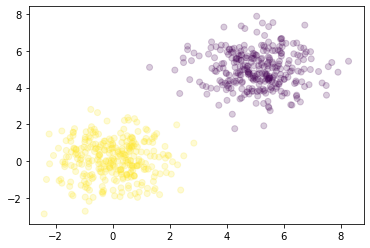

In [41]:
import numpy as np
import matplotlib.pyplot as plt

A = np.random.normal(size=(300,2))
B = np.random.normal(size=(300,2))+5
data = np.concatenate([A,B],axis=0)
color = np.concatenate([np.ones(A.shape[0]),np.zeros(A.shape[0])])

plt.scatter(x=data[:,0],y=data[:,1],c=color,alpha=0.2)
plt.show()

Let us see what happens if the clusters are mixed and nonsymmetric.

Text(0.5, 1.0, 'Gaussian Mixtures')

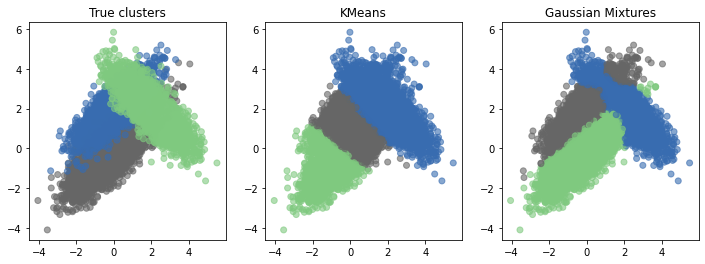

In [42]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(4)

A = np.random.multivariate_normal(mean=[0,0], cov=[(1,0.8),(0.8,1)], size=8000)
B = np.random.multivariate_normal(mean=[0,2], cov=[(1,0.8),(0.8,1)], size=2000)
C = np.random.multivariate_normal(mean=[2,2], cov=[(1,-0.8),(-0.8,1)], size=3000)
data = np.concatenate([A,B,C],axis=0)
color = np.concatenate([np.ones(A.shape[0])*2,np.ones(B.shape[0]),np.zeros(C.shape[0])])


fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].scatter(x=data[:,0],y=data[:,1],c=color,alpha=0.6,cmap=plt.cm.Accent)
ax[0].set_title('True clusters')

from sklearn.cluster import KMeans

km = KMeans(n_clusters=3)
km.fit(data)
ax[1].scatter(x=data[:,0],y=data[:,1],c=km.predict(data),alpha=0.6,cmap=plt.cm.Accent)
ax[1].set_title('KMeans')

from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3,covariance_type='full',n_init=10)
gm.fit(data)
ax[2].scatter(x=data[:,0],y=data[:,1],c=gm.predict(data),alpha=0.6,cmap=plt.cm.Accent)
ax[2].set_title('Gaussian Mixtures')

### Gaussian Mixture

As we saw in the example above, having clusters which are nonsymmetric and mixed does not work very well for `KMeans` while the `Gaussian Mixtures` works very good. In fact, Gaussian Mixtures is the fastest algorithm for learning a gaussian mixture model. 

A mixture model tries to find the components of a **mixture distribution**. A mixture distribution is the probability distribution of a random variable that is derived from a collection of other random variables. The problem that the Gaussian Mixtures algorithm tries to solve is to find the underlying components of the collection. Since it might be that not all components are equally frequent, the model also needs to fit the **mixture weights**:

In [43]:
gm.weights_

array([0.58984673, 0.22468171, 0.18547156])

These weights represent the probability of a randomly chosen point to be in each cluster. As we can see it is fairly close to the simulated values:

In [44]:
np.bincount(color.astype('int'))/color.shape[0]

array([0.23076923, 0.15384615, 0.61538462])

Of course the ordering is not the same. One thing to keep in mind is that the maximization process for Gaussian Mixtures requires some approximations even before we can pose the problem, this approximation method is called [Expectation Maximization](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) and can result in suboptimal clusters. Therefore there is a parameter one can supply and it is called `n_init`, basically it runs the algorithm several times and chooses the best optimum among them.

### Hierarchical Clustering

Both `KMeans` and `Gaussian Mixtures` learn parameters and can make predictions based on these parameters, i.e. given new data points they can predict the cluster that a point should belong to. In Hierarchical clustering we build clusters of the existing data, but this cannot be used to make new predictions. It can still, however, be very useful for data exploration. Let us have a look at the algorithm since it is simple enough to explain in  greater detail:

Basically, Hierarchical clustering comes in two forms:

* Agglomerative
* [Divisive](https://en.wikipedia.org/wiki/Hierarchical_clustering).

We will focus on the agglomerative algorithm. In short, it is a *bottom up* approach where each point starts in a cluster and then each cluster starts to grow and merge until there is only one cluster. Each join is stored in what is called a [dendrogram](https://en.wikipedia.org/wiki/Dendrogram). Depending on what criteria we use to grow each cluster, the algorithm has a few different names (see [sklearn.cluster](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)):

* **Ward:** minimizes the sum of squared differences within all clusters. 
* **Maximum or complete linkage:** minimizes the maximum distance between observations of pairs of clusters.
* **Average linkage:** minimizes the average of the distances between all observations of pairs of clusters.
* **Single linkage:** minimizes the distance between the closest observations of pairs of clusters.

Let us focus on the simplest of them, namely **Single linkage**. Take two clusters $A$ and $B$. We compute the single linkage metric as

$$\min\{d(a,b), a \in A, b \in B\}$$

where $d(a,b)$ is the distance between point $a$ and $b$. We will perform a merge if this distance is smaller than some threshold.

The idea in agglomerative clustering is that we start with threshold $0$, where all data points are in their own cluster. Then we start increasing the threshold value until the threshold is greater than the linkage metric (see above), whereupon we join that pair (or link) of clusters to form one bigger cluster. This is all kept track of in the dendrogram. Let us perform an example:

Text(0.5, 1.0, 'True clusters')

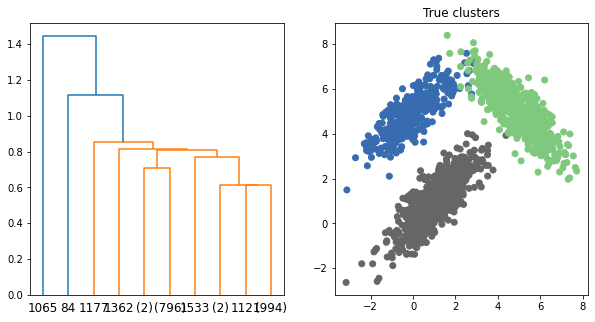

In [45]:
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)

A = np.random.multivariate_normal(mean=[1,1], cov=[(1,0.8),(0.8,1)], size=800)
B = np.random.multivariate_normal(mean=[0,5], cov=[(1,0.8),(0.8,1)], size=400)
C = np.random.multivariate_normal(mean=[5,5], cov=[(1,-0.8),(-0.8,1)], size=600)
data = np.concatenate([A,B,C],axis=0)
color = np.concatenate([np.ones(A.shape[0])*2,np.ones(B.shape[0]),np.zeros(C.shape[0])])

fig,ax = plt.subplots(1,2,figsize=(10,5))
dn = hierarchy.dendrogram(hierarchy.linkage(data,'single'),ax=ax[0],truncate_mode='lastp',p=10)
plt.scatter(data[:,0],data[:,1],c=color,cmap=plt.cm.Accent)
ax[1].set_title("True clusters")

In the dendrogram above we have omitted the smallest clusters since we are only interested in a few clusters. Therefore we can truncate the dendrogram. Above we used `scipy.cluster` to compute the agglomerative clustering. There is actually a package in `sklearn` for this as well, but it is not as easy to plot the dendrogram using that one. The `sklearn` package is more focused on prediction and in that algorithm you chose beforehand which number of clusters you want, as with KMeans and Gaussian Mixtures. 

Text(0.5, 1.0, 'KMeans clustering')

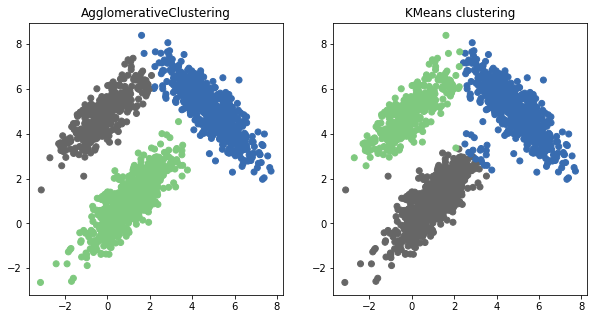

In [46]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

np.random.seed(1)
aggclust = AgglomerativeClustering(n_clusters=3)
colors_prd_agg = aggclust.fit_predict(data)


km = KMeans(n_clusters=3)
colors_prd_km = km.fit_predict(data)

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(data[:,0],data[:,1],c=colors_prd_agg,cmap=plt.cm.Accent)
ax[0].set_title('AgglomerativeClustering')
ax[1].scatter(data[:,0],data[:,1],c=colors_prd_km,cmap=plt.cm.Accent)
ax[1].set_title('KMeans clustering')

As we can see, `AgglomerativeClustering` performs better that `KMeans` in this particular example. In general agglomerative clustering will perform well if the clusters do not mix too much.

***
<center>Combient Mix AB All Rights Reserved</center>

***